## Analysis of Click-Through Rates with Enhanced Filtering

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from pathlib import Path
import json # Though not directly used in analyze_files_for_link_and_stage, it's good practice if dealing with json content

In [2]:
def analyze_files_for_link_and_stage(directory, link_search_term, stage_keywords_list, directory_label):
    """
    Analyzes conversation.json files for a specific link search term AND at least one
    of the specified stage keywords. Returns a list of records for DataFrame creation.

    Args:
        directory (str): The path to the directory to search.
        link_search_term (str): The primary string to look for.
        stage_keywords_list (list): A list of stage keywords.
        directory_label (str): A label for this directory (e.g., 'with_dt', 'without_dt').

    Returns:
        list: A list of dictionaries, where each dictionary contains details of a processed file.
    """
    processed_files_records = []
    base_path = Path(directory)
    total_files_processed = 0

    if not link_search_term or not stage_keywords_list:
        print(f"Warning: Link search term or stage keywords list is empty for directory: {directory_label}.")
        return []

    if not base_path.is_dir():
        print(f"Error: Directory not found: {directory}")
        return []

    stage_keywords_str_display = " OR ".join([f"'{term}'" for term in stage_keywords_list])
    print(f"Analyzing in '{directory_label}' ({directory}) for files containing '{link_search_term}' AND ({stage_keywords_str_display})...")

    for file_path in base_path.rglob('conversation.json'):
        if file_path.is_file():
            total_files_processed += 1
            session_id = file_path.parent.name # Assuming parent folder is the session ID
            record = {
                'session_id': session_id,
                'directory_label': directory_label,
                'file_path': str(file_path),
                'link_term_present': False,
                'stage_keyword_present': False,
                'specific_stage_keyword_found': None,
                'meets_criteria': False,
                'error_processing': None
            }
            
            try:
                content = file_path.read_text(encoding='utf-8')
                
                if link_search_term in content:
                    record['link_term_present'] = True

                if record['link_term_present']:
                    for stage_keyword in stage_keywords_list:
                        if stage_keyword in content:
                            record['stage_keyword_present'] = True
                            record['specific_stage_keyword_found'] = stage_keyword
                            break 
                
                if record['link_term_present'] and record['stage_keyword_present']:
                    record['meets_criteria'] = True
            
            except UnicodeDecodeError:
                record['error_processing'] = "UnicodeDecodeError"
            except IOError as e:
                record['error_processing'] = f"IOError: {e}"
            except Exception as e:
                record['error_processing'] = f"Unexpected error: {e}"
            
            processed_files_records.append(record)

    print(f"  -> Analyzed {total_files_processed} 'conversation.json' files in '{directory_label}'. Found {len([r for r in processed_files_records if r['meets_criteria']])} matching sessions.")
    return processed_files_records

In [3]:
# --- Configuration ---
main_data_file = "combined_conversation_analysis.csv"
output_filtered_file = "click_df_filtered.csv"

directory_with_dt = "../data_output"
directory_without_dt = "../data_output_wout_twin"
link_term_to_search = "youtube.com/"
stage_keywords_to_search = ['LINK_INTRODUCTION', 'LINK_REINFORCEMENT', 'SESSION_COMPLETION']

In [4]:
records_with_dt = analyze_files_for_link_and_stage(
    directory_with_dt, 
    link_term_to_search, 
    stage_keywords_to_search, 
    'with_dt'
)

records_without_dt = analyze_files_for_link_and_stage(
    directory_without_dt, 
    link_term_to_search, 
    stage_keywords_to_search, 
    'without_dt'
)

# Combine records and extract session IDs that meet the criteria
all_relevant_records = records_with_dt + records_without_dt
valid_session_ids = {record['session_id'] for record in all_relevant_records if record['meets_criteria']}
print(f"Total unique session IDs meeting criteria: {len(valid_session_ids)}")

Analyzing in 'with_dt' (../data_output) for files containing 'youtube.com/' AND ('LINK_INTRODUCTION' OR 'LINK_REINFORCEMENT' OR 'SESSION_COMPLETION')...
  -> Analyzed 41 'conversation.json' files in 'with_dt'. Found 22 matching sessions.
Analyzing in 'without_dt' (../data_output_wout_twin) for files containing 'youtube.com/' AND ('LINK_INTRODUCTION' OR 'LINK_REINFORCEMENT' OR 'SESSION_COMPLETION')...
  -> Analyzed 38 'conversation.json' files in 'without_dt'. Found 7 matching sessions.
Total unique session IDs meeting criteria: 29


### Step 2: Load main dataset and filter based on identified session IDs

In [5]:
analysis_df = pd.DataFrame() # Initialize an empty DataFrame

try:
    full_main_df = pd.read_csv(main_data_file)
    if not full_main_df.empty:
        full_main_df['session_id'] = full_main_df['session_id'].astype(str) # Ensure session_id is string for matching
        
        # Filter based on the session IDs obtained from file analysis
        analysis_df = full_main_df[full_main_df['session_id'].isin(valid_session_ids)].copy()
        
        if not analysis_df.empty:
            analysis_df.to_csv(output_filtered_file, index=False)
            print(f"Filtered data saved to {output_filtered_file}. Shape: {analysis_df.shape}")
        else:
            print(f"Warning: No sessions from '{main_data_file}' matched the criteria from file analysis. Resulting DataFrame is empty.")
    else:
        print(f"Warning: Main data file '{main_data_file}' is empty.")
except FileNotFoundError:
    print(f"Error: Main data file '{main_data_file}' not found. Please ensure the file exists in the correct location.")
except Exception as e:
    print(f"Could not load or process '{main_data_file}': {e}")

Filtered data saved to click_df_filtered.csv. Shape: (29, 18)

### Step 3: Data Calculation and Statistical Test using Filtered Data

In [6]:
p_value_text = "p = N/A" # Default text
difference_text = "Difference: N/A"
click_rates_persuasion = [np.nan, np.nan] # Default values: [With DT, Without DT/Control]

if not analysis_df.empty:
    # Ensure 'has_digital_twin' and 'clicked_link' columns exist
    if 'has_digital_twin' not in analysis_df.columns or 'clicked_link' not in analysis_df.columns:
        print("Error: The DataFrame is missing 'has_digital_twin' or 'clicked_link' columns.")
    else:
        # Separate data into 'With Digital Twin' and 'Control Condition' (Without Digital Twin)
        with_dt_df = analysis_df[analysis_df['has_digital_twin'] == True].copy()
        without_dt_df = analysis_df[analysis_df['has_digital_twin'] == False].copy()

        # Check if both groups have data
        if not with_dt_df.empty and not without_dt_df.empty:
            # Calculate click rates
            rate_with_dt = with_dt_df['clicked_link'].mean()
            rate_without_dt = without_dt_df['clicked_link'].mean()
            click_rates_persuasion = [rate_with_dt, rate_without_dt]

            # Calculate difference
            difference = rate_with_dt - rate_without_dt
            difference_text = f"Difference: {difference:+.1%}" # Format as signed percentage

            # --- Perform Chi-squared Test ---
            clicks_with_dt = with_dt_df['clicked_link'].sum()
            total_with_dt = len(with_dt_df)
            no_clicks_with_dt = total_with_dt - clicks_with_dt

            clicks_without_dt = without_dt_df['clicked_link'].sum()
            total_without_dt = len(without_dt_df)
            no_clicks_without_dt = total_without_dt - clicks_without_dt

            contingency_table = np.array([
                [clicks_with_dt, no_clicks_with_dt],
                [clicks_without_dt, no_clicks_without_dt]
            ])

            print("\nContingency Table for Chi-squared Test (based on filtered data):")
            print(f"          Clicked  Not Clicked  Total")
            print(f"With DT    {clicks_with_dt:^7}  {no_clicks_with_dt:^11}  {total_with_dt:^5}")
            print(f"Without DT {clicks_without_dt:^7}  {no_clicks_without_dt:^11}  {total_without_dt:^5}\n")

            try:
                 chi2, p, dof, expected = chi2_contingency(contingency_table, correction=False)
                 if p < 0.001:
                     p_value_text = "p < 0.001"
                 else:
                     p_value_text = f"p = {p:.3f}"
                 print(f"Chi-squared Test Results: chi2={chi2:.3f}, p-value={p:.4f}, dof={dof}")
            except ValueError as e: # Handles cases like all zeros in a row/column
                 print(f"Could not perform Chi-squared test: {e}")
                 p_value_text = "p (test error)"

            difference_text = f"{difference_text} ({p_value_text})"

        else:
            print("Warning: One or both groups ('With DT', 'Without DT') are empty after filtering and separation. Cannot calculate difference or p-value.")
            if with_dt_df.empty: click_rates_persuasion[0] = 0.0
            if without_dt_df.empty: click_rates_persuasion[1] = 0.0
else:
    print("Analysis DataFrame is empty. Skipping calculations and plotting.")


Contingency Table for Chi-squared Test (based on filtered data):
          Clicked  Not Clicked  Total
With DT      18          4        22  
Without DT    3          4         7  

Chi-squared Test Results: chi2=4.035, p-value=0.0446, dof=1


### Step 4: Plotting Results

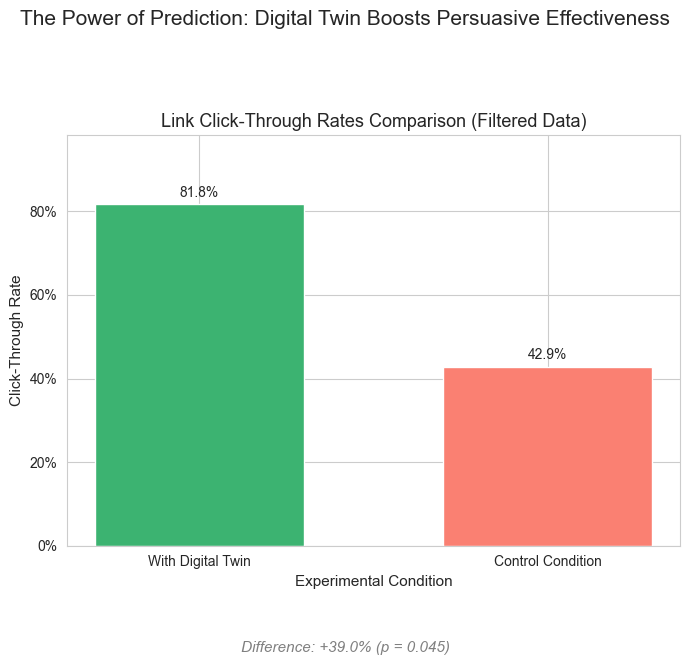

In [7]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(7, 6)) # Increased figure size slightly
fig.suptitle('The Power of Prediction: Digital Twin Boosts Persuasive Effectiveness', fontsize=15, y=1.04)

categories = ['With Digital Twin', 'Control Condition']
colors = ['mediumseagreen', 'salmon']

# Create the bars using calculated rates (or defaults if data was missing)
bars = ax.bar(categories, click_rates_persuasion, color=colors, width=0.6)

# --- Customize Appearance ---
ax.set_title('Link Click-Through Rates Comparison (Filtered Data)', fontsize=13)
ax.set_ylabel('Click-Through Rate', fontsize=11)
ax.set_xlabel('Experimental Condition', fontsize=11)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

# Add bar labels, handle potential NaN values gracefully
for bar in bars:
    yval = bar.get_height()
    if pd.notna(yval): # Check if the value is not NaN
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.1%}', ha='center', va='bottom', fontsize=10)
    else:
        ax.text(bar.get_x() + bar.get_width()/2.0, 0.01, 'N/A', ha='center', va='bottom', fontsize=10) # Display N/A for NaN
        
ax.set_ylim(0, max(0.1, np.nanmax(click_rates_persuasion) * 1.2 if pd.notna(click_rates_persuasion).any() else 0.1)) # Adjust y-limit dynamically, ensure at least 10%

# Add the dynamically calculated difference text
fig.text(0.5, -0.03, difference_text, ha='center', fontsize=11, style='italic', color='gray')

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust rect to accommodate suptitle and custom text
plt.show()